### Import Dependencies

In [268]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report

plt.style.use('bmh')

### Data Exploration

In [270]:
data = pd.read_csv("cover_data.csv")
# data.describe()
data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,class
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [271]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581012 non-null 

We can see that from the above information, all features seems to be relevant and there are no null values which is great. All our features are integers, which makes our preprocessing one step easier

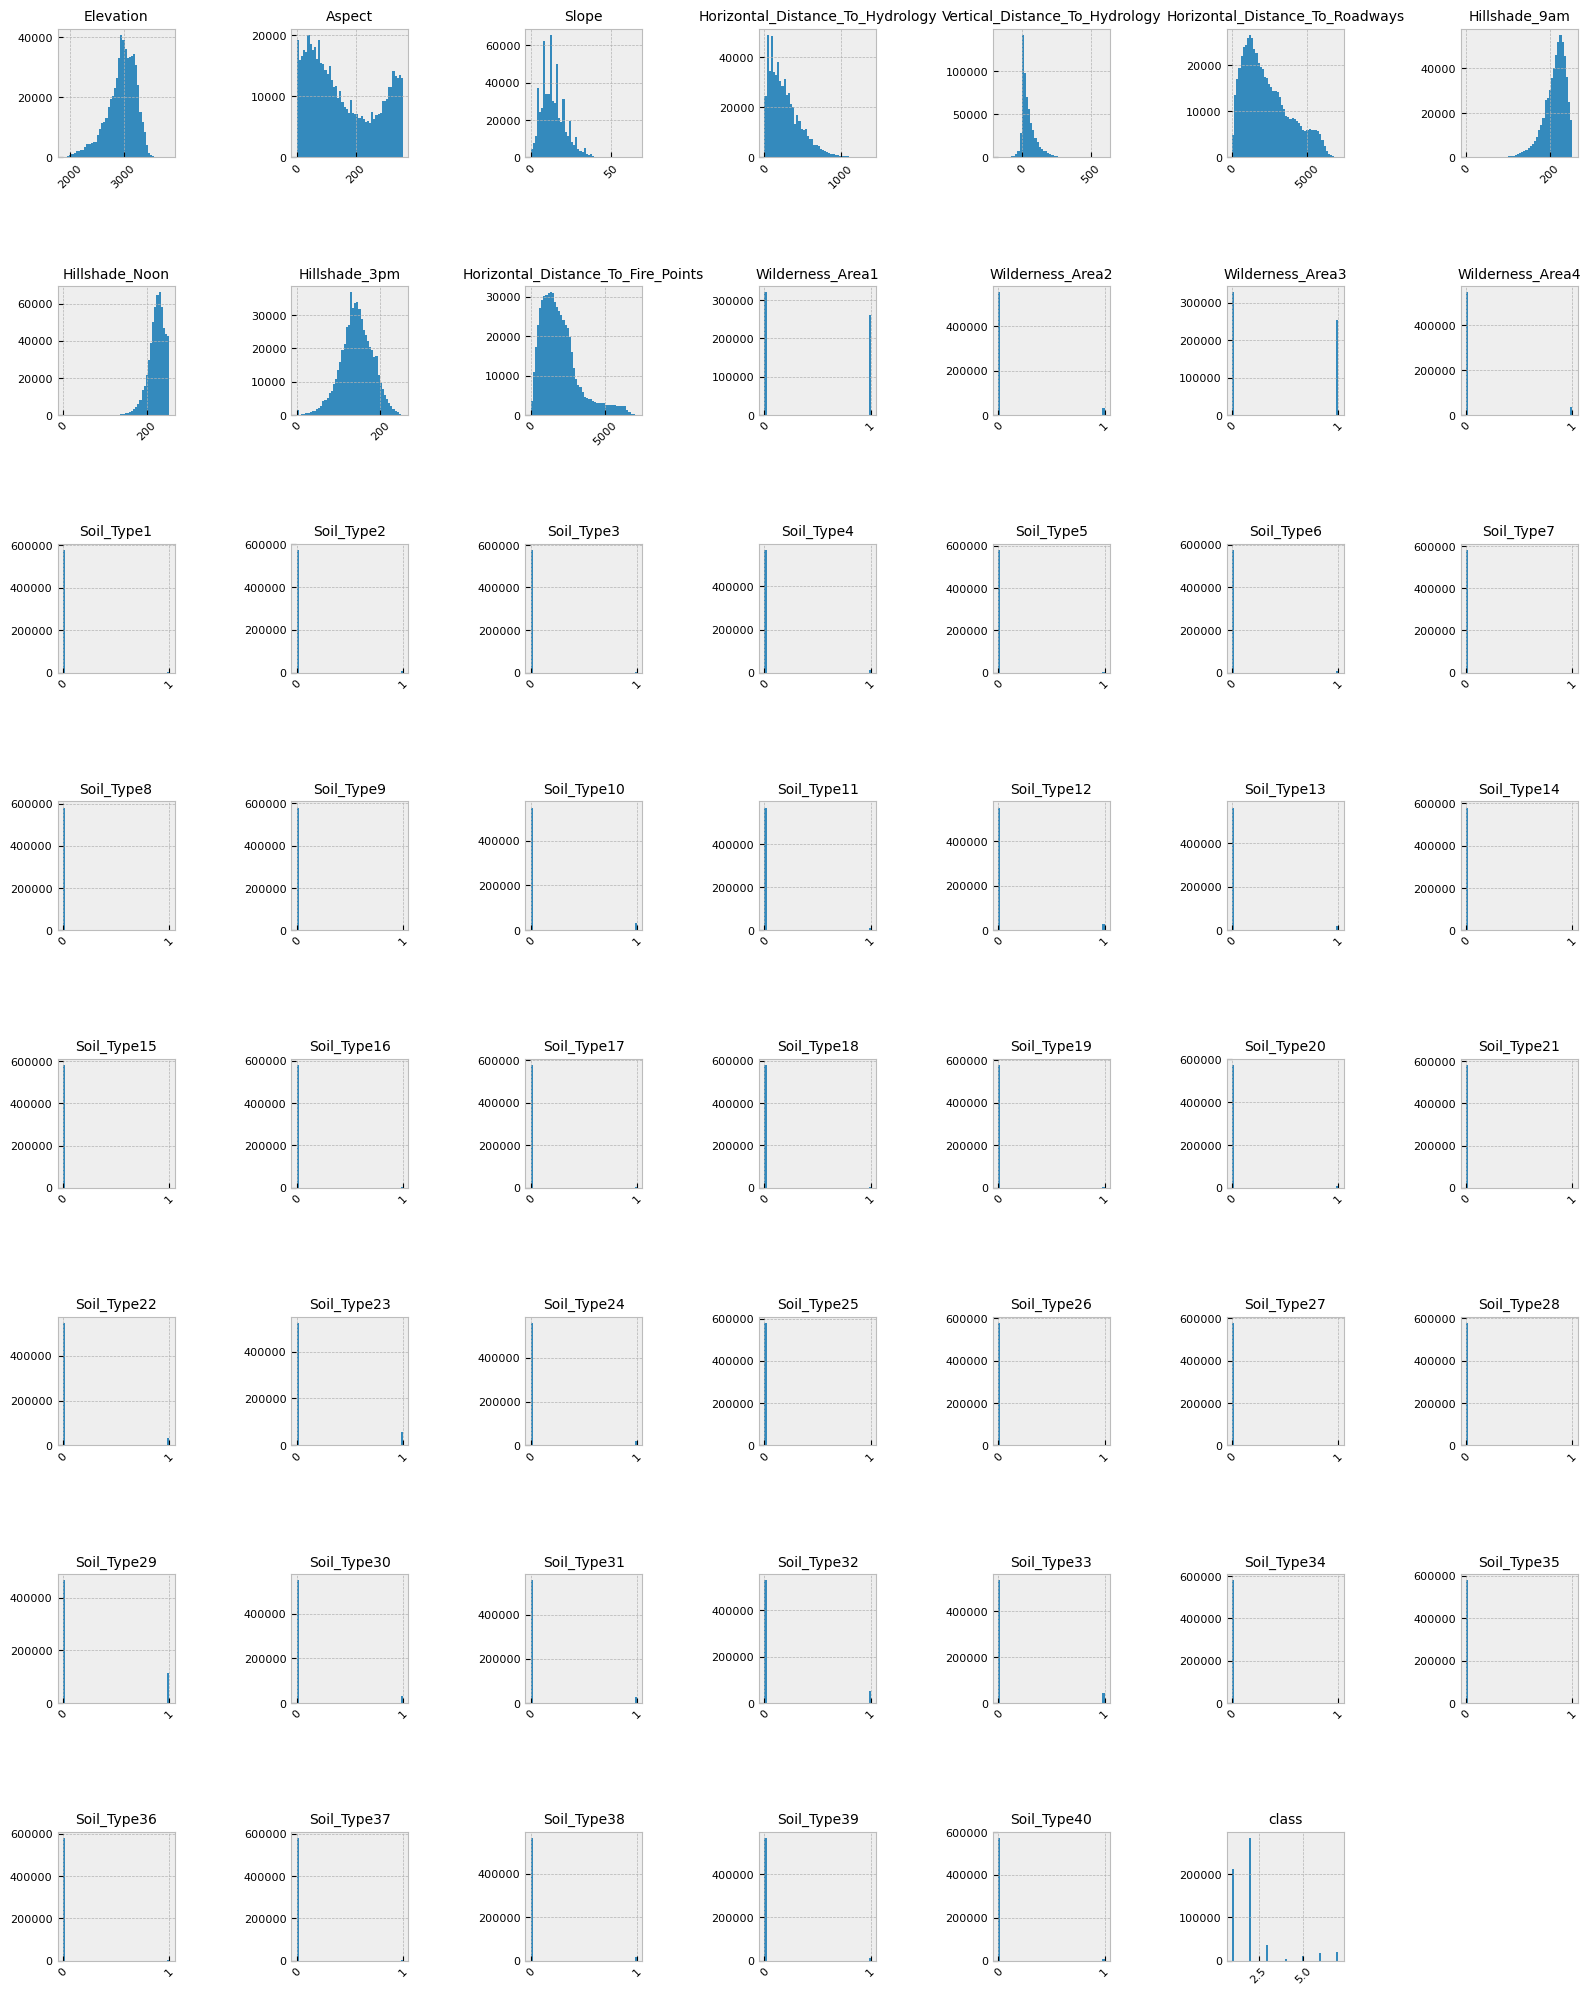

In [273]:
# Plot histograms
axes = data.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)
plt.tight_layout() 

# Apply formatting because of overlapping titles
for ax in axes.flatten():
    ax.set_title(ax.get_title(), fontsize=10) 
    ax.tick_params(axis='x', rotation=45)

plt.subplots_adjust(hspace=1, wspace=1)


In [274]:
Counter(data["class"])

Counter({2: 283301, 1: 211840, 3: 35754, 7: 20510, 6: 17367, 5: 9493, 4: 2747})

**Important consideration**: We see heavy imbalance in class distribution, class 2 and 1 significantly outnumbering the other classes

### Split Dataset

In [277]:
label = data["class"]
features = features = data.iloc[:, :-1]
# Stratify split helps equalize proportion
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, stratify=label, random_state=42)
features.shape

(581012, 54)

### Preprocess and Normalize DataSet


It is quite evident as we saw from our exploration that all features and label are numerical, however features are in different scales, hence a need for standardization

*Wilderness_Area and Soil Type column-types are binary, therefore there is no need for scaling*

In [279]:
continuous_features = [
    'Elevation', 
    'Aspect', 
    'Slope', 
    'Horizontal_Distance_To_Hydrology', 
    'Vertical_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways', 
    'Hillshade_9am', 
    'Hillshade_Noon', 
    'Hillshade_3pm', 
    'Horizontal_Distance_To_Fire_Points'
]
binary_features = [col for col in data.columns if 'Wilderness_Area' in col or 'Soil_Type' in col]
numerical_preprocessor = StandardScaler()
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
ct = ColumnTransformer(
    [
        ("standard_scaler", numerical_preprocessor, continuous_features),
        ("one-hot-encoder", categorical_preprocessor, binary_features),
    ]
)
X_train = ct.fit_transform(X_train) # Fit transformer only on training data to avoid exposing test data
X_test = ct.transform (X_test)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

### Examine Preprocessed and Standardized Dataset

In [281]:
# Convert the transformed data back to a DataFrame

# Get features names from transformer
feature_names = ct.get_feature_names_out()


X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

X_train_df.head()

,standard_scaler__Elevation,standard_scaler__Aspect,standard_scaler__Slope,standard_scaler__Horizontal_Distance_To_Hydrology,standard_scaler__Vertical_Distance_To_Hydrology,standard_scaler__Horizontal_Distance_To_Roadways,standard_scaler__Hillshade_9am,standard_scaler__Hillshade_Noon,standard_scaler__Hillshade_3pm,standard_scaler__Horizontal_Distance_To_Fire_Points,...,one-hot-encoder__Soil_Type36_0,one-hot-encoder__Soil_Type36_1,one-hot-encoder__Soil_Type37_0,one-hot-encoder__Soil_Type37_1,one-hot-encoder__Soil_Type38_0,one-hot-encoder__Soil_Type38_1,one-hot-encoder__Soil_Type39_0,one-hot-encoder__Soil_Type39_1,one-hot-encoder__Soil_Type40_0,one-hot-encoder__Soil_Type40_1
0,0.755252,0.206925,0.787406,0.003068,0.027120,0.260485,0.406155,1.248611,0.116390,0.917245,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.383857,0.421250,1.588777,-1.268183,-0.797161,0.669635,-0.527975,1.450951,0.874223,-0.897553,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,1.508757,1.600035,-1.349584,-0.505432,-0.402193,0.701058,-0.042228,0.540423,0.508372,0.210819,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0.383857,0.778458,-0.681775,-0.561932,-0.522401,0.295756,-0.341149,1.198026,1.031016,-1.011639,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,-0.855320,-0.864698,0.653844,-0.505432,-0.093088,-1.395995,0.667711,-1.381801,-1.373145,-0.096684,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [282]:
Counter(y_train)

Counter({1: 226640, 0: 169472, 2: 28603, 6: 16408, 5: 13894, 4: 7594, 3: 2198})

We observe that our data has been preprocessed as follows:
* features with continous values are now standardized to use same scales
* multiple columns are added for features with binary values as expected of one-hot-encoding
* labels are now labelled from 0 to 6 as opposed to 1 to 7 in original dataset

### Create Model

In [307]:
model = Sequential()
# Input Layer
model.add(layers.InputLayer(shape=(X_train.shape[1], )))

# Hidden Layers
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))

# Output Layer
model.add(layers.Dense(7, activation='softmax'))

opt = Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy', 'sparse_categorical_crossentropy'])

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 64)             │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,647 (33.78 KB)

 Trainable params: 8,647 (33.78 KB)

 Non-trainable params: 0 (0.00 B)

### Fit and Evaluate Model

In [287]:
hist = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=0)

In [288]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
# y_true = np.argmax(y_test, axis=1)
classification_report(y_test, y_pred)

3632/3632 ━━━━━━━━━━━━━━━━━━━━ 1s 214us/step


'              precision    recall  f1-score   support\n\n           0       0.79      0.68      0.73     42368\n           1       0.75      0.87      0.81     56661\n           2       0.80      0.62      0.70      7151\n           3       0.70      0.37      0.49       549\n           4       0.74      0.13      0.23      1899\n           5       0.45      0.57      0.50      3473\n           6       0.82      0.73      0.77      4102\n\n    accuracy                           0.76    116203\n   macro avg       0.72      0.57      0.60    116203\nweighted avg       0.76      0.76      0.75    116203\n'

### Plot Performance Graphs

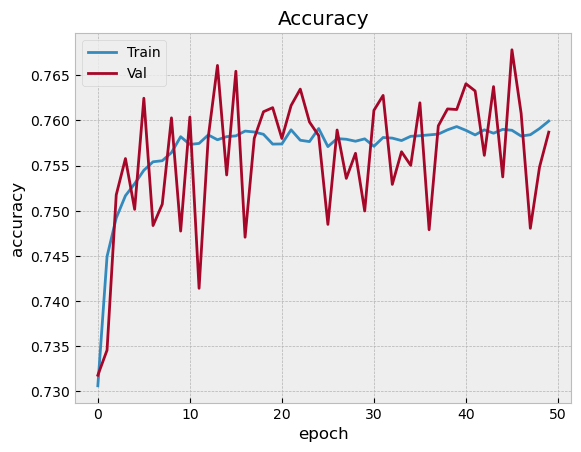

In [290]:
# Plotting accuracy against epoch
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
# hist.history

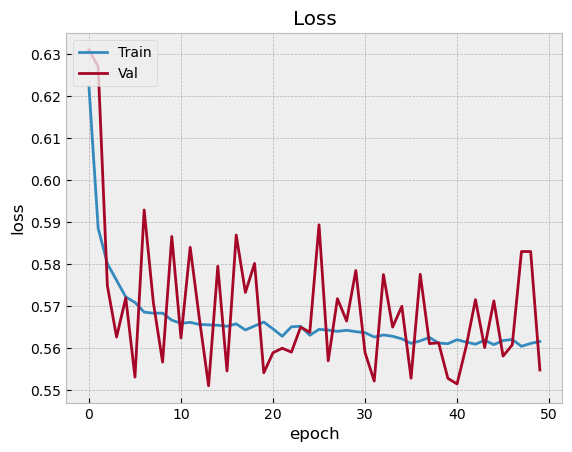

In [291]:
# Plotting loss against epoch
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
# hist.history